In [1]:
# Imports
import pandas as pd
from pathlib import Path
import numpy as np


from tvDatafeed import TvDatafeed, Interval

# Initiate trading view API
tv=TvDatafeed()

you are using nologin method, data you access may be limited


### Read the CSV file into Pandas DataFrame

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
# trading_df = pd.read_csv(
#     Path("../Resources/ohlcv.csv"), 
#     index_col="date", 
#     infer_datetime_format=True, 
#     parse_dates=True
# )

name=input("Enter Stock Ticker").upper()
trading_df=tv.get_hist(name, 'NASDAQ', interval=Interval.in_5_minute, n_bars=5000)
trading_df = trading_df.drop(columns=["symbol"])

# Review the DataFrame
trading_df.head()

Enter Stock Ticker TSLA


,open,high,low,close,volume
datetime,,,,,
2022-08-05 15:20:00,286.589713,286.726380,285.666381,286.056381,44862.0
2022-08-05 15:25:00,286.266380,287.233046,286.266380,287.233046,32658.0
2022-08-05 15:30:00,287.216379,287.216379,286.749713,287.033046,15126.0
2022-08-05 15:35:00,286.806380,286.956380,286.049714,286.049714,40320.0
2022-08-05 15:40:00,286.006381,286.779713,286.006381,286.779713,34701.0


### Add a daily return values column to the DataFrame

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,actual_returns
datetime,,,,,,
2022-08-05 15:25:00,286.266380,287.233046,286.266380,287.233046,32658.0,0.004113
2022-08-05 15:30:00,287.216379,287.216379,286.749713,287.033046,15126.0,-0.000696
2022-08-05 15:35:00,286.806380,286.956380,286.049714,286.049714,40320.0,-0.003426
2022-08-05 15:40:00,286.006381,286.779713,286.006381,286.779713,34701.0,0.002552
2022-08-05 15:45:00,286.763047,288.933044,286.763047,288.549711,66804.0,0.006172


,open,high,low,close,volume,actual_returns
datetime,,,,,,
2022-11-04 15:35:00,207.07,207.28,206.73,206.99,27913.0,-0.000241
2022-11-04 15:40:00,206.95,207.18,206.80,207.18,42319.0,0.000918
2022-11-04 15:45:00,207.17,207.24,206.53,206.53,44554.0,-0.003137
2022-11-04 15:50:00,206.61,206.86,206.13,206.42,79811.0,-0.000533
2022-11-04 15:55:00,206.43,207.58,206.40,207.37,141979.0,0.004602


---

### Generating the Features and Target Sets

In [4]:
# Define a window size of 20
short_window = 20

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

In [5]:
# Define a window size of 200
long_window = 200

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()

In [6]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

In [7]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
datetime,,
2022-08-10 12:30:00,290.159710,290.239010
2022-08-10 12:35:00,290.173043,290.253843
2022-08-10 12:40:00,290.120377,290.272693
2022-08-10 12:45:00,290.107710,290.292793
2022-08-10 12:50:00,290.155543,290.313893


,sma_fast,sma_slow
datetime,,
2022-11-04 15:35:00,206.1020,215.81965
2022-11-04 15:40:00,206.2845,215.73690
2022-11-04 15:45:00,206.4475,215.65255
2022-11-04 15:50:00,206.5705,215.56880
2022-11-04 15:55:00,206.6605,215.48995


#### Create the target set

In [8]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

In [9]:
# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [10]:
# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [11]:
# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [12]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [13]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2022-08-10 12:30:00


In [14]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=1)

# Display the training end date
print(training_end)

2022-09-10 12:30:00


In [15]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
datetime,,
2022-08-10 12:30:00,290.159710,290.239010
2022-08-10 12:35:00,290.173043,290.253843
2022-08-10 12:40:00,290.120377,290.272693
2022-08-10 12:45:00,290.107710,290.292793
2022-08-10 12:50:00,290.155543,290.313893


#### Creating the Testing Datasets

In [16]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
datetime,,
2022-09-12 09:30:00,299.3695,289.902575
2022-09-12 09:35:00,299.5130,290.025325
2022-09-12 09:40:00,299.7615,290.156875
2022-09-12 09:45:00,300.0360,290.289975
2022-09-12 09:50:00,300.3350,290.420825


#### Standardizing the Data

In [17]:
# Imports
from sklearn.preprocessing import StandardScaler

In [18]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [19]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [20]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [21]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.78      0.62       848
         1.0       0.53      0.25      0.34       832

    accuracy                           0.52      1680
   macro avg       0.52      0.52      0.48      1680
weighted avg       0.52      0.52      0.48      1680



In [22]:
pd.DataFrame([training_signal_predictions]).T.value_counts()

-1.0    1287
 1.0     393
dtype: int64

---

### Backtesting a Machine Learning Trading Algorithm

In [23]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [24]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.91      0.64      1536
         1.0       0.47      0.08      0.13      1584

    accuracy                           0.49      3120
   macro avg       0.48      0.49      0.39      3120
weighted avg       0.48      0.49      0.38      3120



In [25]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
datetime,,,
2022-09-12 09:30:00,1.0,0.011577,0.011577
2022-09-12 09:35:00,1.0,-0.003166,-0.003166
2022-09-12 09:40:00,1.0,0.006551,0.006551
2022-09-12 09:45:00,1.0,0.001413,0.001413
2022-09-12 09:50:00,1.0,0.000788,0.000788


<AxesSubplot:xlabel='datetime'>

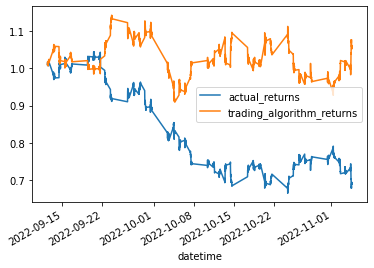

In [26]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Import the `LogisticRegression` model from scikit-learn.


In [27]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [28]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()


## Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [29]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression()

## Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [30]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions =  logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions


array([-1., -1., -1., ..., -1., -1., -1.])

In [31]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)


              precision    recall  f1-score   support

        -1.0       0.51      0.69      0.59       848
         1.0       0.52      0.34      0.41       832

    accuracy                           0.51      1680
   macro avg       0.52      0.51      0.50      1680
weighted avg       0.52      0.51      0.50      1680



## Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [32]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [33]:
# Generate a classification report using the testing data and the logistic regression model's predications
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.50      0.26      0.34      1536
         1.0       0.51      0.75      0.61      1584

    accuracy                           0.51      3120
   macro avg       0.51      0.50      0.48      3120
weighted avg       0.51      0.51      0.48      3120



## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [34]:
# Print the classification report for the SVM model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)


Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.26      0.34      1536
         1.0       0.51      0.75      0.61      1584

    accuracy                           0.51      3120
   macro avg       0.51      0.50      0.48      3120
weighted avg       0.51      0.51      0.48      3120



In [35]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)


SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.91      0.64      1536
         1.0       0.47      0.08      0.13      1584

    accuracy                           0.49      3120
   macro avg       0.48      0.49      0.39      3120
weighted avg       0.48      0.49      0.38      3120



### Answer the following question:

**Question:** Did the `LogisticRegression` perform better than the `SVM`?

**Answer:** Maybe. The logistic regression model performs a bit better than the SVM model since it has a higher accuracy score. However, the SVM model does a better job predicting profitable short opportunities, as evidenced by its higher recall score on the -1.0 class. Ultimately, which model is best may depend on which class we care most about predicting, as well as which has better overall economic returns compared to a long-only investment.